# Provably Safe NN Controllers and Their Implementations

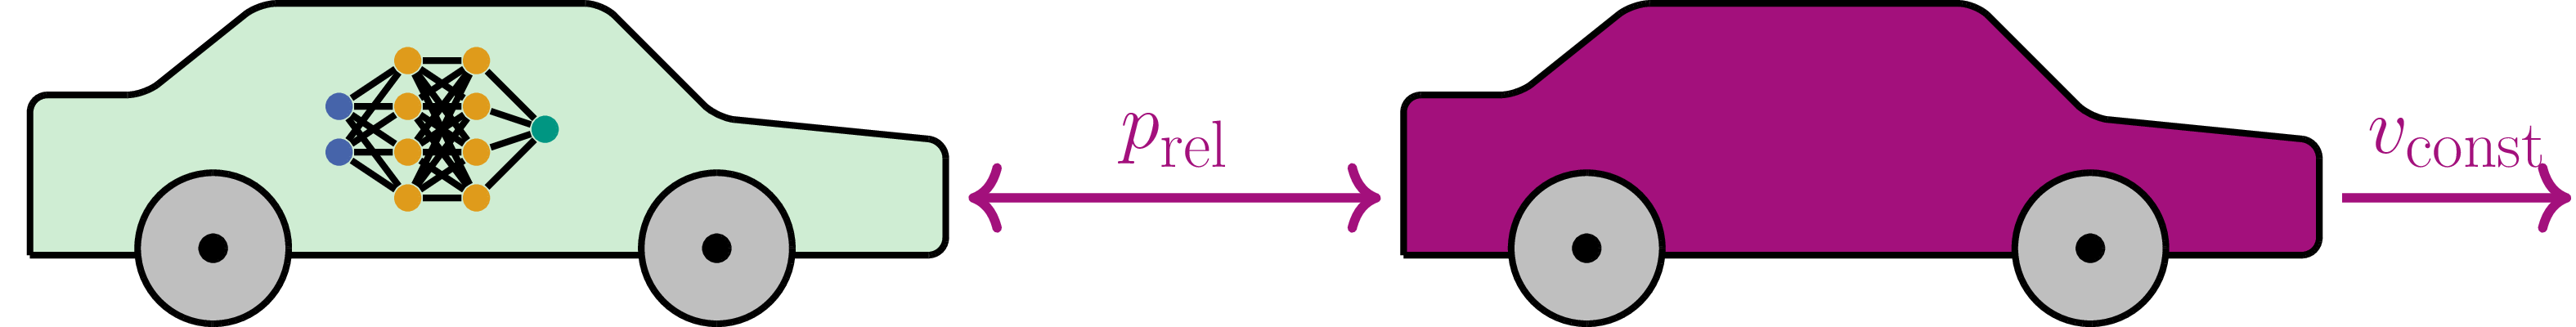

In [1]:
import libs.acc
from libs.gym_helper import *
import gymnasium as gym
from gymnasium import wrappers

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
import time
import numpy as np

set_random_seed(0)

# Initialize Evaluation Environment for ACC
eval_env = Monitor(gym.make('acc-discrete-v0'))

BRAKE = 2, None

ACCELERATE = 0, None

# A naive controller
### ... and what can go wrong

In [2]:
def control(state,**kwargs):
    relativePosition, relativeVelocity = state
    # Break if we are getting too close...
    if relativePosition+relativeVelocity < 0:
        return BRAKE
    else:
        return ACCELERATE

show_run(eval_env, control, obs=[50,-8])

We should **verify** our control software!

# KeYmaera X

## ...

# But what about Neural Control?

In [4]:
env1 = get_env1()
model1 = train_model1(env1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Performing some training steps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 74.6     |
|    ep_rew_mean     | 98.2     |
| time/              |          |
|    fps             | 2752     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 71.7        |
|    ep_rew_mean          | 98.2        |
| time/                   |             |
|    fps                  | 1818        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010781969 |
|    clip_fraction        | 0.0993      |
|    clip_range           | 

In [5]:
show_run(eval_env, model1.predict, obs=[50,-8])

**NN Controller should be verified, too!**

# Training a better model...

## ...takes more time than we have right now

In [6]:
good_nn = load_good_model()

# dl-based safety verification for Neural Networks

In [7]:
! cat property/formula

(
(0<=prel & prel<=100 & -34 <= vrel & vrel <= 34 &
-100000 <= x1post & x1post <= 100000  & -100000 <= x2post & x2post <= 100000  & -100000 <= x3post & x3post <= 100000) &
(prel >= 0 & prel >= vrel^2 / (2*B))
)
->
(
x1post >= x2post &
x1post >= x3post &
prel + T * vrel + (-A) * T^2 / 2 >= (vrel + T * (-A))^2 / (2 * B) &
(
  -2 * vrel / (-A) > T |
  prel + (-2 * vrel / (-A)) * vrel + (-2 * vrel / (-A))^2 * (-A) / 2 >=
  (vrel + (-2 * vrel / (-A)) * (-A))^2 / (2 * B)
) |
x2post >= x1post &
x2post >= x3post &
prel + T * vrel >= vrel^2 / (2 * B) |
x3post >= x2post &
x3post >= x1post &
prel + T * vrel + B * T^2 / 2 >= (vrel + T * B)^2 / (2 * B) &
(
  -2 * vrel / B > T |
  prel + (-2 * vrel / B) * vrel + (-2 * vrel / B)^2 * B / 2 >=
  (vrel + (-2 * vrel / B) * B)^2 / (2 * B)
)
)

# dl-based safety verification for Neural Networks

The specifications we generate:
- Have **arbitrary propositional structure**
- Contain **polynomial arithmetic**

In [8]:
! NCubeV property/formula property/fixed property/mapping good_nn.onnx ./results_good

[CMD] Using SMT solver: Z3
[CMD] Using verifier: NNEnum
[CMD] Parsed initial query: SNNT.AST.Query(((-1.0*x1<=0.0&((-1.0*prel)+(0.0909090909090909*(vrel^2.0)))<=0.0&-1.0*x1<=0.0&1.0*x1<=100.0&-1.0*x2<=34.0&1.0*x2<=34.0&-1.0*x3<=100000.0&1.0*x3<=100000.0&-1.0*x4<=100000.0&1.0*x4<=100000.0&-1.0*x5<=100000.0&1.0*x5<=100000.0)->((-1.0*x31.0*x4<=0.0&-1.0*x31.0*x5<=0.0&(0.024236363636363636+(-1.0*prel)+(-0.056363636363636366*vrel)+(-0.1*vrel)+(0.0909090909090909*(vrel^2.0)))<=0.0&(-0.65*x2<-0.1|((-1.0*prel)+(0.0909090909090909*(vrel^2.0))+(-0.6451612903225807*(vrel^2.0))+(0.6451612903225806*(vrel^2.0)))<=0.0))|(1.0*x3-1.0*x4<=0.0&-1.0*x41.0*x5<=0.0&((-1.0*prel)+(-0.1*vrel)+(0.0909090909090909*(vrel^2.0)))<=0.0)|(1.0*x4-1.0*x5<=0.0&1.0*x3-1.0*x5<=0.0&(-1.380069548931996e-79+(-1.0*prel)+(-0.1*vrel)+(0.09999999999999999*vrel)+(0.0909090909090909*(vrel^2.0)))<=0.0&(0.36*x2<-0.1|((-1.0*prel)+(0.3636363636363636*(vrel^2.0))+(0.0909090909090909*(vrel^2.0))+(-0.36363636363636365*(vrel^2.0)))<=0.0)))

# So what does safe driving look like?

In [9]:
show_run(eval_env, good_nn, obs=[50,-8])

# But what about numerical imprecisions?

## ...

In [10]:
! NCubeV property/formula-num property/fixed property/mapping-num good_nn-num.onnx ./results_good

[CMD] Using SMT solver: Z3
[CMD] Using verifier: NNEnum
[CMD] Parsed initial query: SNNT.AST.Query(((-1.0*x1<=0.0&((-1.0*prel)+(0.0909090909090909*(vrel^2.0)))<=0.0&-1.0*x3<=-0.01&1.0*x3<=0.01&-1.0*x4<=-0.01&1.0*x4<=0.01&-1.0*x5<=-0.01&1.0*x5<=0.01&-1.0*x1<=0.0&1.0*x1<=100.0&-1.0*x2<=34.0&1.0*x2<=34.0&-1.0*x6<=100000.0&1.0*x6<=100000.0&-1.0*x7<=100000.0&1.0*x7<=100000.0&-1.0*x8<=100000.0&1.0*x8<=100000.0)->((-1.0*x31.0*x4-1.0*x61.0*x7<=0.0&-1.0*x31.0*x5-1.0*x61.0*x8<=0.0&(0.024236363636363636+(-1.0*prel)+(-0.056363636363636366*vrel)+(-0.1*vrel)+(0.0909090909090909*(vrel^2.0)))<=0.0&(-0.65*x2<-0.1|((-1.0*prel)+(0.0909090909090909*(vrel^2.0))+(-0.6451612903225807*(vrel^2.0))+(0.6451612903225806*(vrel^2.0)))<=0.0))|(1.0*x3-1.0*x41.0*x6-1.0*x7<=0.0&-1.0*x41.0*x5-1.0*x71.0*x8<=0.0&((-1.0*prel)+(-0.1*vrel)+(0.0909090909090909*(vrel^2.0)))<=0.0)|(1.0*x4-1.0*x51.0*x7-1.0*x8<=0.0&1.0*x3-1.0*x51.0*x6-1.0*x8<=0.0&(-1.380069548931996e-79+(-1.0*prel)+(-0.1*vrel)+(0.09999999999999999*vrel)+(0.090909